In [1]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [2]:
image_directory = 'simage/'
mask_directory = 'slabel_binary/'

In [3]:
SIZE = (96,128,3)
num_images = 700

Load images and masks in order so they match

In [4]:
image_names = glob.glob("simage/*.png")
#print(image_names)

In [5]:
image_names.sort()
#print(image_names)

In [6]:
#image_names_subset = image_names[0:num_images]

In [7]:
images = [cv2.imread(img) for img in image_names]

In [8]:
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 4)

Read masks the same way. 

In [9]:
mask_names = glob.glob("slabel_binary/*.png")
mask_names.sort()
#mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask,0) for mask in mask_names]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [10]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (701, 96, 128, 3)
Mask data shape is:  (701, 96, 128, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [11]:
#scaler = MinMaxScaler()

In [12]:
#test_image_data=scaler.fit_transform(image_dataset_uint8.reshape(-1, image_dataset_uint8.shape[-1])).reshape(image_dataset_uint8.shape)

In [13]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


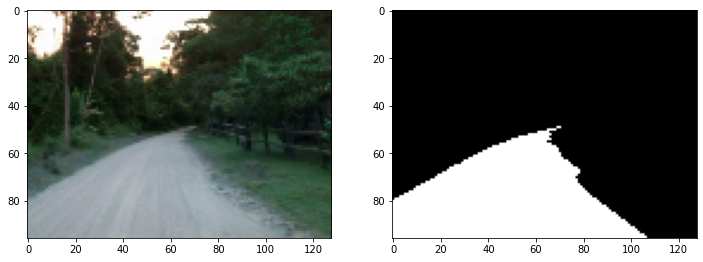

In [15]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,:])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,:], cmap='gray')
plt.show()

In [16]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, concatenate, Dropout,\
                                    Lambda, Conv2DTranspose, Add
#from config import imshape, n_classes, model_name
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import os


def fcn_model(input_size=(92, 128, 3), n_filters=5, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
        
    """
    b = n_filters
    i = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    x = Conv2D(2**b, (3, 3), activation='elu', padding='same', name='block1_conv1')(i)
    x = Conv2D(2**b, (3, 3), activation='elu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x

    # Block 2
    x = Conv2D(2**(b+1), (3, 3), activation='elu', padding='same', name='block2_conv1')(x)
    x = Conv2D(2**(b+1), (3, 3), activation='elu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x

    # Block 3
    x = Conv2D(2**(b+2), (3, 3), activation='elu', padding='same', name='block3_conv1')(x)
    x = Conv2D(2**(b+2), (3, 3), activation='elu', padding='same', name='block3_conv2')(x)
    x = Conv2D(2**(b+2), (3, 3), activation='elu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    pool3 = x

    # Block 4
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block4_conv1')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block4_conv2')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block5_conv2')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    conv6 = Conv2D(2048 , (7, 7) , activation='elu' , padding='same', name="conv6")(pool5)
    conv6 = Dropout(0.5)(conv6)
    conv7 = Conv2D(2048 , (1, 1) , activation='elu' , padding='same', name="conv7")(conv6)
    conv7 = Dropout(0.5)(conv7)

    pool4_n = Conv2D(n_classes, (1, 1), activation='elu', padding='same')(pool4)
    u2 = Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7)
    u2_skip = Add()([pool4_n, u2])

    pool3_n = Conv2D(n_classes, (1, 1), activation='elu', padding='same')(pool3)
    u4 = Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(u2_skip)
    u4_skip = Add()([pool3_n, u4])

    o = Conv2DTranspose(n_classes, kernel_size=(8, 8), strides=(8, 8), padding='same',
                        activation='sigmoid')(u4_skip)

    model = Model(inputs=i, outputs=o)
    return model

In [17]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(96, 128, 3)


In [18]:
img_height = 96
img_width = 128
num_channels = 3

fcn = fcn_model((img_height, img_width, num_channels))
fcn.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
fcn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 128, 32)  9248        block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 64, 32)   0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [48]:
history = fcn.fit(X_train, y_train, 
                    batch_size = 5, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/2
112/112 [==============================] - 186s 2s/step - loss: 0.3031 - accuracy: 0.8697 - val_loss: 0.2934 - val_accuracy: 0.8754
Epoch 2/2
112/112 [==============================] - 171s 2s/step - loss: 0.3028 - accuracy: 0.8696 - val_loss: 0.2932 - val_accuracy: 0.8754


In [29]:
#Save the model for future use
fcn.save('FCN2.h5')

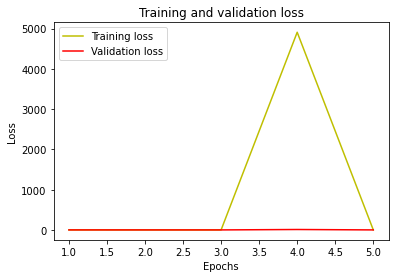

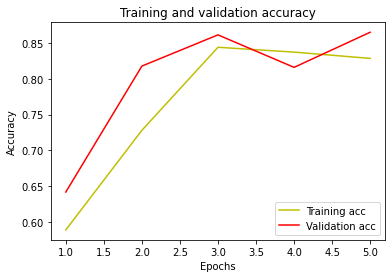

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

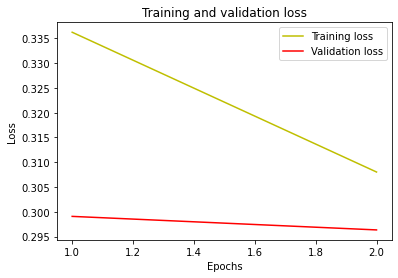

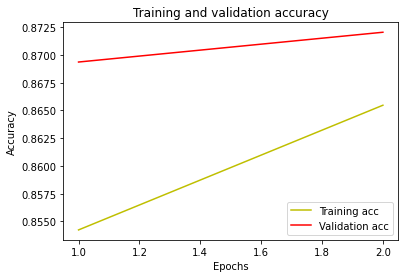

In [30]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
#Load previously saved model
from keras.models import load_model
model = load_model("FCN2.h5", compile=False)
        

In [32]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [33]:
from tensorflow.keras.metrics import MeanIoU

In [39]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7590921


(1, 96, 128, 3)
(96, 128, 1)


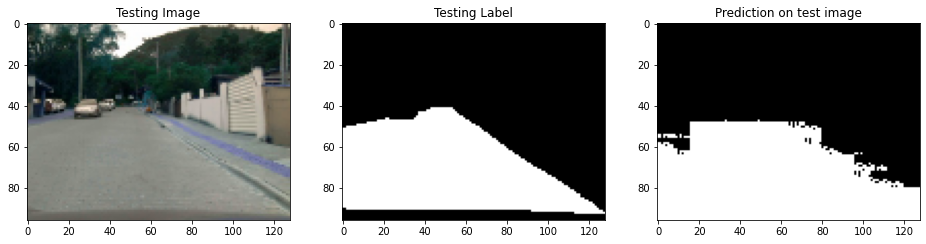

In [63]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img,0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,:] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

# The conventional FCN model has some limitations
### It does not take into account the global context information in an efficient way.
### It is not fast enough for real-time inference.